In [1]:
import pandas as pd
import networkx as nx
from tqdm import tqdm
from collections import Counter

l = []

p1e6 = pd.read_csv("../data/ge_ge_results_1e-6_0.8.tsv", sep="\t")

p1e6 = p1e6[p1e6["PP.H4"] >= 0.8]

cs_keys = {
    "_".join(node.rsplit('_', 1)[:-1])
    for node in list(p1e6['signal1'].unique()) + list(p1e6['signal2'].unique())
}

removed_counts = {}
duplicate_percentage = 0

G = nx.Graph()
G.add_edges_from(zip(p1e6['signal1'], p1e6['signal2']))

total = 0
dup = 0
for comp in tqdm(nx.connected_components(G),leave=False):
    total += 1
    nodes = list(comp)
    key_counts = Counter(n.rsplit('_', 1)[0] for n in nodes)
    if any(k in cs_keys and cnt >= 2 for k, cnt in key_counts.items()):
        dup += 1

duplicate_percentage = (dup / total * 100) if total else 0

duplicate_percentage

2.546081421562127

In [2]:
import numpy as np

l = []

clpp = pd.read_csv("../data/ge_ge_clpp.tsv", sep="\t")

clpp = clpp.drop_duplicates(subset=["signal_a", "signal_b"])

clpp = clpp[(clpp["clpp"]>=0.04)]

df = p1e6.merge(clpp, left_on=['signal1', 'signal2'], right_on=['signal_a', 'signal_b'], how="outer")

credible_sets = np.load("../data/FinnGen_and_eQTL_Catalogue_credible_sets.npy", allow_pickle=True).tolist()

df = df.dropna(subset=["signal1", "signal2"])
df["signal1_cs"] = df["signal1"].isin(credible_sets)
df["signal2_cs"] = df["signal2"].isin(credible_sets)

df["Category"] = "Neither"
df.loc[df["signal1_cs"] & df["signal2_cs"], "Category"] = "Both CS"
df.loc[df["signal1_cs"] & ~df["signal2_cs"], "Category"] = "One CS"
df.loc[~df["signal1_cs"] & df["signal2_cs"], "Category"] = "One CS"

df["CLPP_hit"] = df["signal_a"].notna()

df = df[~(df["Category"].isin(["Both CS"]) & ~df["CLPP_hit"])]

cs_keys = {
    "_".join(node.rsplit('_', 1)[:-1])
    for node in list(p1e6['signal1'].unique()) + list(p1e6['signal2'].unique())
}

removed_counts = {}
duplicate_percentage = 0

G = nx.Graph()
G.add_edges_from(zip(df['signal1'], df['signal2']))

total = 0
dup = 0
for comp in tqdm(nx.connected_components(G), leave=False):
    total += 1
    nodes = list(comp)
    key_counts = Counter(n.rsplit('_', 1)[0] for n in nodes)
    if any(k in cs_keys and cnt >= 2 for k, cnt in key_counts.items()):
        dup += 1

duplicate_percentage = (dup / total * 100) if total else 0

duplicate_percentage

2.485851800920294

In [3]:
import re
import pandas as pd
import numpy as np
import networkx as nx
from tqdm import tqdm
from collections import Counter

strip_suffix = lambda s: re.sub(r'_L\d+$', '', s)
cs_keys = {strip_suffix(node) for node in credible_sets}

l= []

for i in tqdm(range(1000)):
    rng = np.random.default_rng()  
    drop_idx = rng.choice(p1e6.index, size=422496, replace=False)

    df_filt = p1e6.drop(index=drop_idx).copy()

    G = nx.Graph()
    G.add_edges_from(zip(df_filt['signal1'], df_filt['signal2']))

    if G.number_of_nodes() < 2:
        l.append(0)
        continue

    total = dup = 0
    for comp in tqdm(nx.connected_components(G), leave=False):
        total += 1
        nodes = list(comp)
        key_counts = Counter(strip_suffix(n) for n in nodes)
        if any(k in cs_keys and cnt >= 2 for k, cnt in key_counts.items()):
            dup += 1

    l.append((dup / total * 100) if total else 0)

dataframe = pd.DataFrame({'dup_pct': l})
dataframe.describe(), dataframe["dup_pct"].mean(), dataframe["dup_pct"].std()

  1%|          | 6/1000 [00:47<2:11:57,  7.97s/it]


KeyboardInterrupt: 

In [4]:
import pandas as pd
import numpy as np
import networkx as nx
from tqdm import tqdm
from collections import Counter

l = []

df = p1e6.merge(clpp, left_on=['signal1', 'signal2'], right_on=['signal_a', 'signal_b'], how="outer")

df = df.dropna(subset=["signal1", "signal2"])
df["signal1_cs"] = df["signal1"].isin(credible_sets)
df["signal2_cs"] = df["signal2"].isin(credible_sets)

df["Category"] = "Neither"
df.loc[df["signal1_cs"] & df["signal2_cs"], "Category"] = "Both CS"
df.loc[df["signal1_cs"] & ~df["signal2_cs"], "Category"] = "One CS"
df.loc[~df["signal1_cs"] & df["signal2_cs"], "Category"] = "One CS"

df = df[~df["Category"].isin(["Neither", "One CS"])]

cs_keys = {
    "_".join(node.rsplit('_', 1)[:-1])
    for node in list(p1e6['signal1'].unique()) + list(p1e6['signal2'].unique())
}

removed_counts = {}
duplicate_percentage = 0

G = nx.Graph()
G.add_edges_from(zip(df['signal1'], df['signal2']))

total = 0
dup = 0
for comp in tqdm(nx.connected_components(G), leave=False):
    total += 1
    nodes = list(comp)
    key_counts = Counter(n.rsplit('_', 1)[0] for n in nodes)
    if any(k in cs_keys and cnt >= 2 for k, cnt in key_counts.items()):
        dup += 1

duplicate_percentage = (dup / total * 100) if total else 0

duplicate_percentage



1.2028845873113194

In [5]:
import pandas as pd
import numpy as np
import networkx as nx
from tqdm import tqdm
from collections import Counter

l = []


df = p1e6.merge(clpp, left_on=['signal1', 'signal2'], right_on=['signal_a', 'signal_b'], how="inner")

df = df.dropna(subset=["signal1", "signal2"])
df = df.dropna(subset=["signal_a", "signal_b"])

df = df.drop_duplicates(subset=["signal1", "signal2"])
df = df.drop_duplicates(subset=["signal_a", "signal_b"])

credible_sets = np.load("all_credible_sets.npy", allow_pickle=True).tolist()
cs_keys = {
    "_".join(node.rsplit('_', 1)[:-1])
    for node in list(p1e6['signal1'].unique()) + list(p1e6['signal2'].unique())
}

removed_counts = {}
duplicate_percentage = 0

G = nx.Graph()
G.add_edges_from(zip(df['signal_a'], df['signal_b']))

total = 0
dup = 0
for comp in tqdm(nx.connected_components(G), leave=False):
    total += 1
    nodes = list(comp)
    key_counts = Counter(n.rsplit('_', 1)[0] for n in nodes)
    if any(k in cs_keys and cnt >= 2 for k, cnt in key_counts.items()):
        dup += 1

duplicate_percentage = (dup / total * 100) if total else 0

duplicate_percentage



FileNotFoundError: [Errno 2] No such file or directory: 'all_credible_sets.npy'

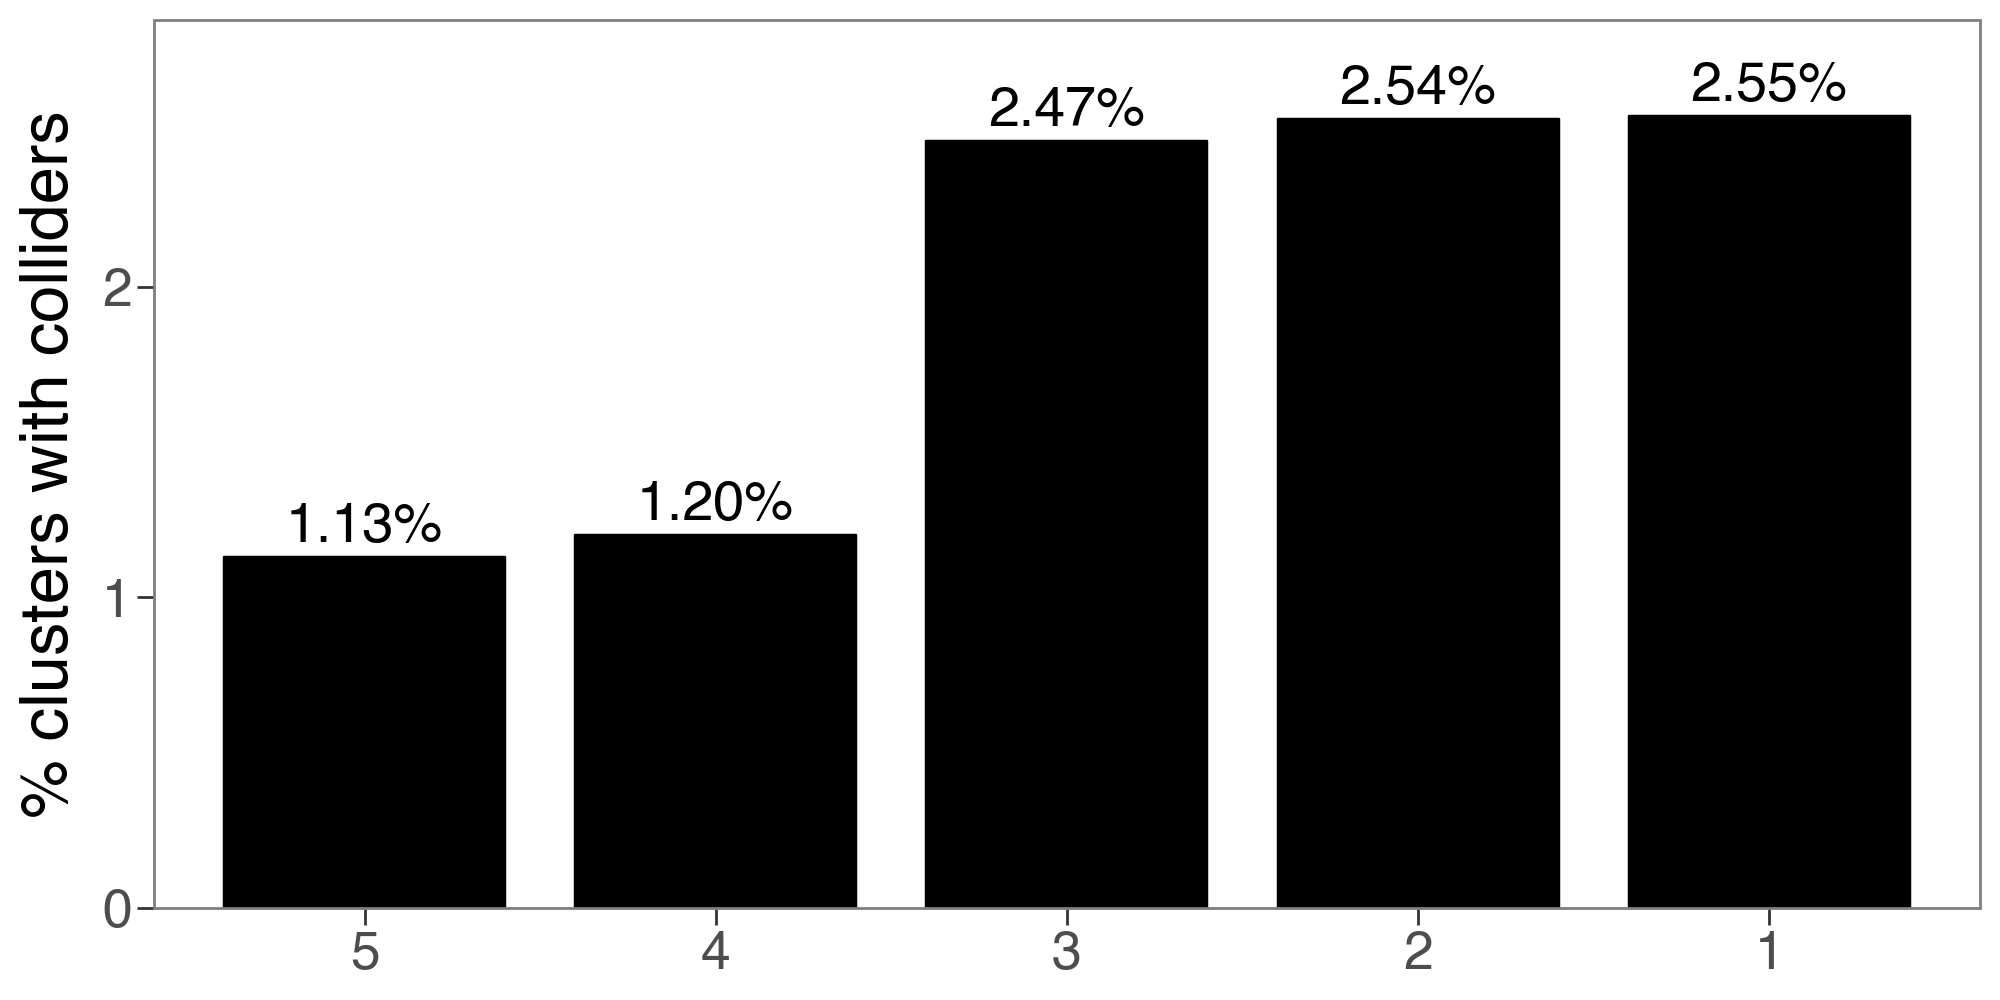

In [ ]:
import pandas as pd
from plotnine import (
    geom_text, ggplot, aes, geom_bar, labs, scale_y_continuous,
    theme_bw, theme, element_blank
)

d = {
    "1": 2.55,
    "2": 2.54,
    "4": 1.20,
    "3": 2.47,
    "5": 1.13
}

df = (pd.DataFrame(d.items(), columns=['index', 'value'])
        .sort_values('value', ascending=True))

df['index'] = pd.Categorical(df['index'],
                             categories=df['index'],
                             ordered=True)

df["label"] = df["value"].apply(lambda x: f"{x:.2f}%")

(
    ggplot(df, aes(x='index', y='value'))
    + geom_bar(stat='identity', width=.8,
               fill='black', colour='black', show_legend=False)
    + labs(x='', y='% clusters with colliders')
    + theme_bw(base_size=24)
    + theme(
        figure_size=(10, 5),
        panel_grid=element_blank()
    )
    + scale_y_continuous(expand=(0, 0, 0, 0.3))  
    + geom_text(aes(label="label"), 
                va="bottom",            
                nudge_y=0.01,          
                size=20)        
)


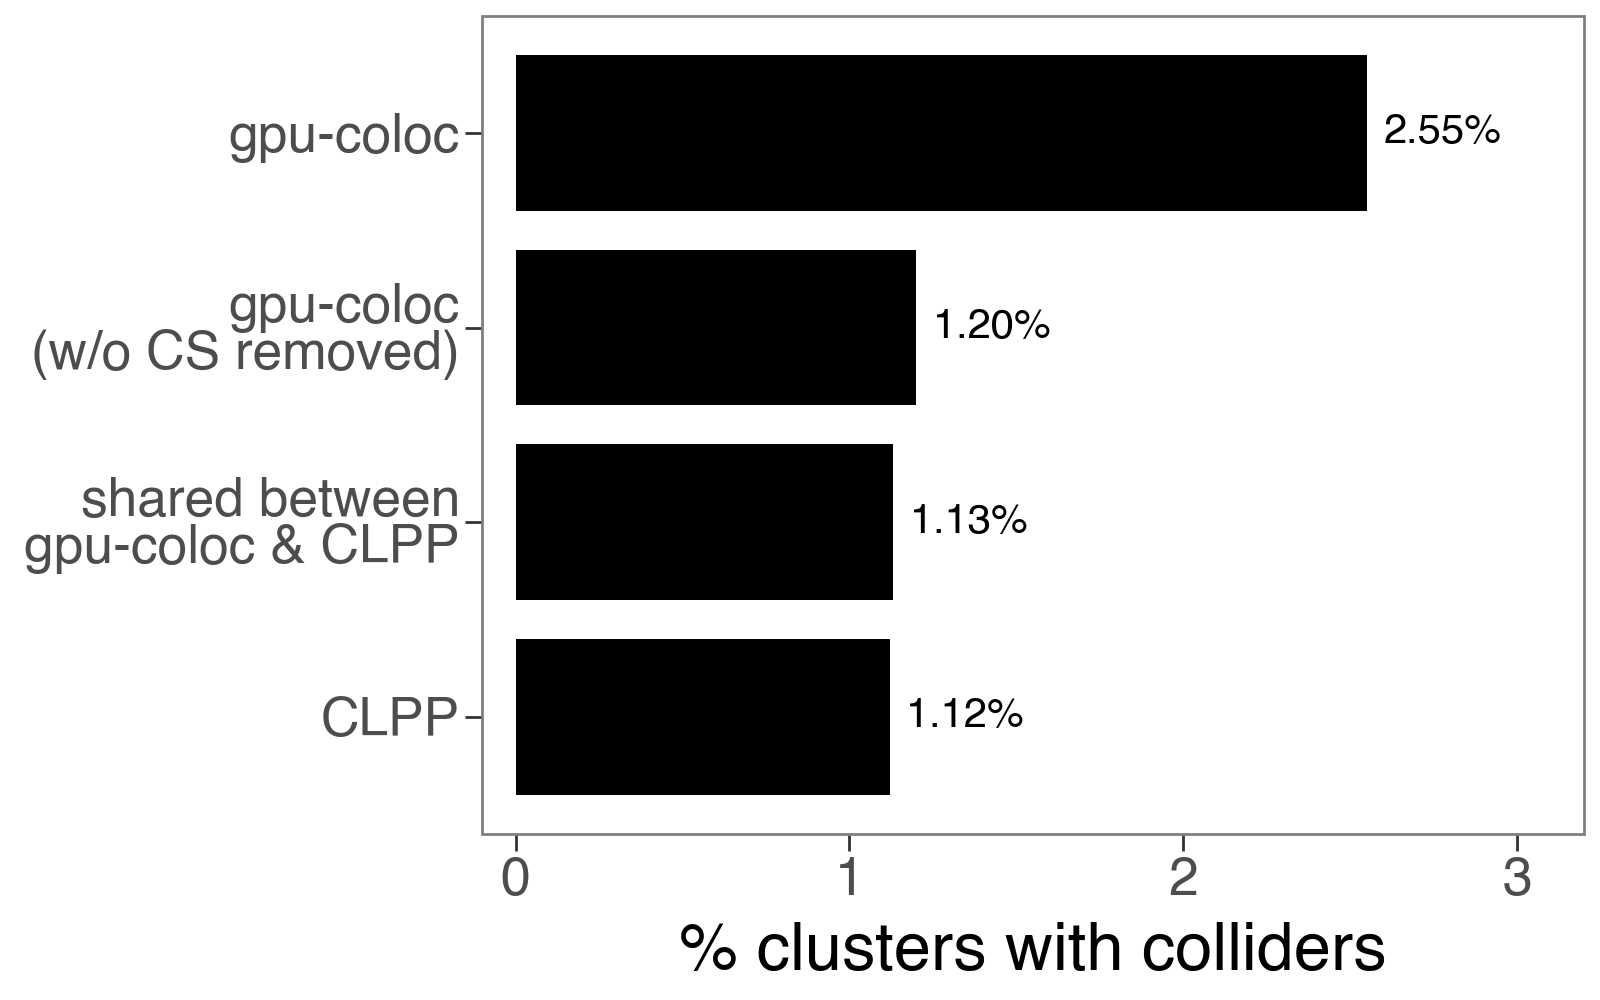

In [ ]:
from plotnine import *
import pandas as pd

d = {
    "gpu-coloc": 2.55,
    "gpu-coloc\n (w/o CS removed)": 1.20,
    "CLPP": 1.12,
    "shared between\ngpu-coloc & CLPP": 1.13
}

df = (pd.DataFrame(d.items(), columns=['index', 'value'])
        .sort_values('value', ascending=True))
df['index'] = pd.Categorical(df['index'], categories=df['index'], ordered=True)
df['label'] = df['value'].apply(lambda x: f'{x:.2f}%')

gap = 0.05      
pad = 0.6        

(
    ggplot(df, aes(x='index', y='value'))
    + geom_bar(stat='identity', width=.8, fill='black')


    + geom_text(aes(label='label'),       ha='left',  nudge_y= gap, size=15)

    + coord_flip()
    + scale_y_continuous(expand=(0, 0.1 ,0, pad)) 
    + labs(x='', y='% clusters with colliders')
    + theme_bw(base_size=24)
    + theme(panel_grid=element_blank(), figure_size=(8, 5))
)
